Notebook for the diffusion development program

In [1]:
import model.diffusion as gd
diffusion = gd.create_diffusion_model(model_path="saved_models/diffusion/molecule-diffusion-v1.pt").to('cuda')

/home/alden/miniconda3/envs/pytorch-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Model created successfully
- Total parameters: 57,314,049
- Trainable parameters: 57,314,049
- Model size: 218.6 MB
- Device: cuda:0
- Model Name: LatentDiffusionModel


/home/alden/Research/GDProject/model/diffusion/load.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [2]:
device = 'cuda'

In [3]:
import torch
from model.classifier.logp_predictor import LogPPredictor
logp_predictor : LogPPredictor = torch.load(f="saved_models/logp/model-logp", weights_only=False).to(device)

In [4]:
import model.vae
vae = model.vae.load_vae_selfies().to(device)

loading model from saved_models/selfies_vae/selfies-vae.ckpt
Enc params: 1,994,592
Dec params: 277,346


/home/alden/Research/GDProject/model/vae/util.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path_to_vae_statedict, map_location=device)["state

In [5]:

def get_cond_fn(log_prob_fn, guidance_strength: float = 1.0, latent_dim: int = 128, clip_grad=False, clip_grad_max=10.0, debug=False):
    '''
        log_prob_fn --> maps a latent z of shape (B, 128) into a log probability
        guidance_strength --> the guidance strength of the model
        latent_dim --> the latent dim (always 128)
        clip_grad --> if the model should clip the gradient to +-clip_grad_max

        Returns a cond_fn that evaluastes the grad of the log probability
    '''

    def cond_fn(mean, t, **kwargs):
        # mean.shape = (B, 1, 128), so reshape to (B, 128) so predicter can handle it
        mean = mean.detach().reshape(-1, latent_dim)
        mean.requires_grad_(True)

        # if debug:
            # print(f"mean: {mean}")
            # print(f"mean.shape: {mean.shape}")
            # print(f"mean.requires_grad: {mean.requires_grad}")


        #---------------------------------------------------------------------------

        with torch.enable_grad():
            predicted_log_probability = log_prob_fn(mean)
            if debug:
                print(f"pred_log_prob: {predicted_log_probability}")
                print(f"pred_log_prob.shape: {predicted_log_probability.shape}")
                print(f"pred_log_prob.requires_grad {predicted_log_probability.requires_grad}")
                
            gradients = torch.autograd.grad(predicted_log_probability, mean, retain_graph=True)[0]

            # if debug:
                # print(f"gradients: {gradients}")
                # print(f"graidents.shape: {gradients.shape}")
                # print(f"gradients.requires_grad {gradients.requires_grad}")
                
            if clip_grad:
                if debug:
                    print(f"Clipping gradients to {-clip_grad_max} to {clip_grad_max}")
                gradients = torch.clamp(gradients, -clip_grad_max, clip_grad_max)
                
            grads = guidance_strength * gradients.reshape(-1, 1, latent_dim)
            if debug:
                # print(f"grads: {grads}")
                print(f"grad_norm: {grads.norm(2)}")
                print(f"grads.shape: {grads.shape}")
                # print(f"grads.requires_grad {grads.requires_grad}")
                
            return grads
        
    return cond_fn


In [6]:
# Tests to check if guided diffusion is working
do_diffusion_tests = True
# vae = vae.double().to(device)
from torch.distributions import Normal

def get_cond_fn_normal_analytical(mean=0.0, sigma=0.001):
    # analytically computes the gradient of the log probability under
    # a normal distribution with mean=mean, sigma=sigma

    def cond_fn(z, t, **guidance_kwargs):
        z = z.to(device)
        grad = -(z - mean) / (sigma**2)

        # MUST clamp gradient for numerical stability
        # It is REALLY finnicky about how much you clamp
        # not ideal really...

        grad = torch.clamp(grad, min=-100.0, max=100.0)
        return grad
    
    return cond_fn

def _diffusion_test_one():
    # Test 1. Get all of the latent values to be 0.5
    # -------------------------------------------------

    cond_fn_normal_dist = get_cond_fn_normal_analytical(mean=-0.5, sigma=0.01)
    z = diffusion.sample(batch_size=16, cond_fn=cond_fn_normal_dist)

    # Should print is different from diffusion
    # is_different_from_diffusion(z, alpha=0.01)

    # Should be normal centered around 0.2
    # plot_latent(z[0])

# Test the shapes are working
def _diffusion_test_two():
    # Prior that the logps of my molecules should be ~20.0
    logp_distribution = Normal(loc=20.0, scale=1.0)

    # log probability function that gives the probability of the logps of z
    # under the logp_distribution

    def log_prob_fn_logp(z):
        # We cant backprop thru the evaluate_logp function, so we 
        # instead have this predictor trained on latent, logp pairs:
        pred_logp = logp_predictor(z)

        # get the log_probability under the normal distribution with mean=20.0
        log_prob = logp_distribution.log_prob(pred_logp).sum(dim=0)

        # the log probability must be a single value
        assert(log_prob.shape == (1, ))
        return log_prob
    
    z_random = torch.randn(16, 1, 128, device=device)
    cond_fn_logp = get_cond_fn(log_prob_fn=log_prob_fn_logp, guidance_strength=1.0)

    grad_log_prob = cond_fn_logp(mean = z_random, t = 0)

    # shape of grad of log prob must be equal to input shape as they
    # are added
    assert(z_random.shape == grad_log_prob.shape)
    
def _diffusion_test_three():
    # Do diffusion and inspect results
    logp_distribution = Normal(loc=100.0, scale=1.0)

    def log_prob_fn_logp(z):
        pred_logp = logp_predictor(z)
        log_prob = logp_distribution.log_prob(pred_logp).sum(dim=0)
        return log_prob

    cond_fn_logp = get_cond_fn(
        log_prob_fn=log_prob_fn_logp, 
        guidance_strength=1.0, 
        clip_grad=True, 
        clip_grad_max=1.0,
    )

    z = diffusion.sample(batch_size=16, cond_fn=cond_fn_logp)
    # display_logp_info(z)
    return z
    

if do_diffusion_tests:
    # Test 1. Test we can force latent to an arbitrary value
    # _diffusion_test_one()

    # Test 2. Test shapes work out
    _diffusion_test_two()

    # Test 3. Get a high logP molecule with basic guided diffusion
    z_out = _diffusion_test_three()
   
    

DDPM Sampling loop time step: 100%|██████████| 1000/1000 [00:11<00:00, 85.87it/s]


In [ ]:
# z = diffusion.sample(batch_size=16)

DDPM Sampling loop time step: 100%|██████████| 1000/1000 [00:09<00:00, 103.97it/s]


In [7]:
smiles = model.vae.latent_to_smiles(z=z_out, vae=vae)

In [8]:
import util.chem as chem
chem.calculate_logp(smiles)

[15.730999999999957,
 20.7172,
 17.00739999999997,
 13.70809999999997,
 15.97179999999996,
 16.725099999999962,
 20.4037,
 19.89539999999999,
 12.883699999999978,
 13.592299999999971,
 19.02559999999999,
 12.32896999999998,
 26.209000000000046,
 12.295399999999981,
 15.500399999999958,
 13.370499999999975]

In [9]:
import util.visualization as vis

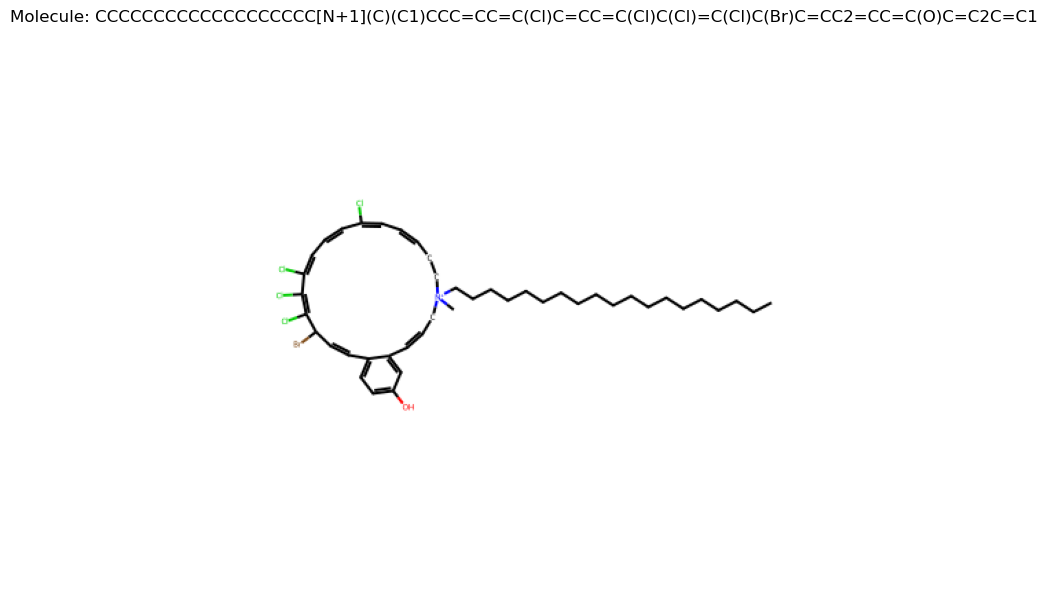

SMILES: CCCCCCCCCCCCCCCCCCC[N+1](C)(C1)CCC=CC=C(Cl)C=CC=C(Cl)C(Cl)=C(Cl)C(Br)C=CC2=CC=C(O)C=C2C=C1


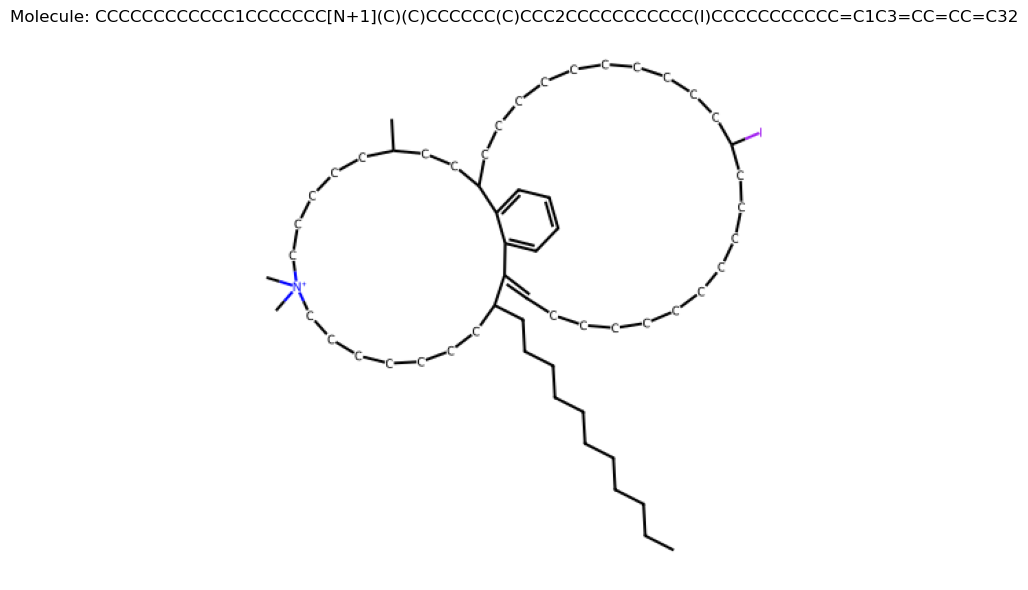

SMILES: CCCCCCCCCCCC1CCCCCCC[N+1](C)(C)CCCCCC(C)CCC2CCCCCCCCCCC(I)CCCCCCCCCCC=C1C3=CC=CC=C32


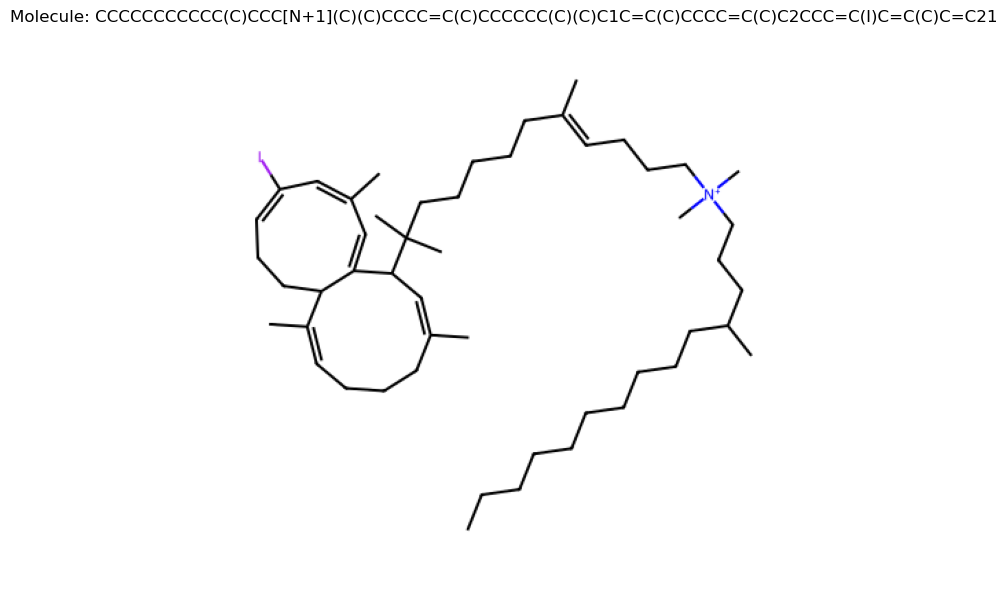

SMILES: CCCCCCCCCCC(C)CCC[N+1](C)(C)CCCC=C(C)CCCCCC(C)(C)C1C=C(C)CCCC=C(C)C2CCC=C(I)C=C(C)C=C21


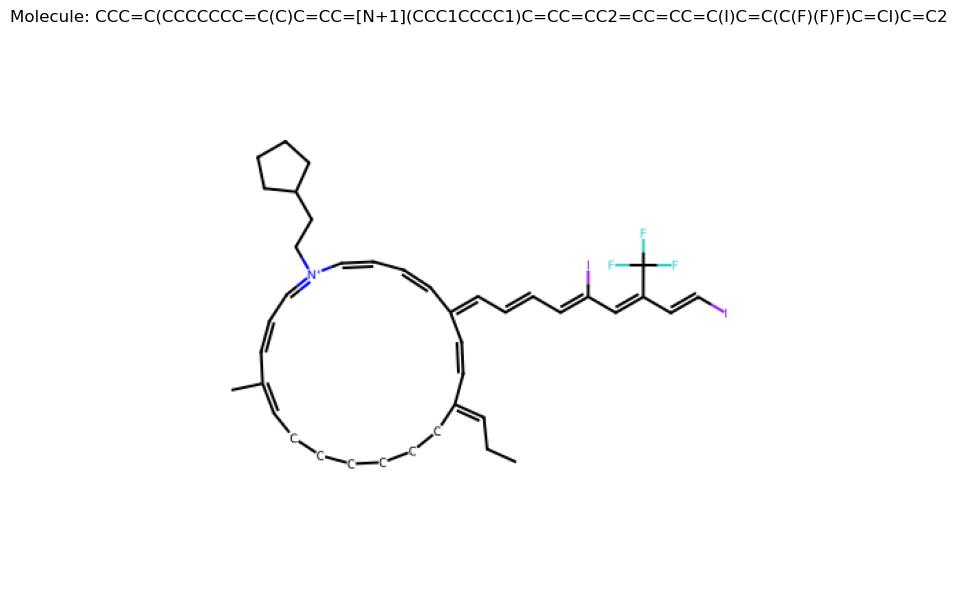

SMILES: CCC=C(CCCCCCC=C(C)C=CC=[N+1](CCC1CCCC1)C=CC=CC2=CC=CC=C(I)C=C(C(F)(F)F)C=CI)C=C2


In [12]:
for i in range(4):
    vis.display_molecule(smiles[i])